In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import librosa
from sklearn.preprocessing import StandardScaler, LabelEncoder
from joblib import Parallel, delayed
import scipy.signal as signal
from tqdm import tqdm
import gc

In [3]:
# Reading the CSV files into DataFrames
metadata_df = pd.read_csv('/kaggle/input/birdclef-2022/train_metadata.csv')
taxonomy_df = pd.read_csv('/kaggle/input/birdclef-2022/eBird_Taxonomy_v2021.csv')

#filtering the metadata to havings ratings of >= 3
filtered_metadata_df = metadata_df[metadata_df['rating'] >= 3]
print(f"\nTotal number of after filtering ratings of >= 3:")
len(filtered_metadata_df)


Total number of after filtering ratings of >= 3:


12646

In [4]:
from collections import Counter
import re

# List of columns to analyze
columns_to_analyze = ['secondary_labels', 'type']

# Function to analyze each column with individual string components, case-insensitive and space-insensitive
def analyze_column_individual_case_insensitive(df, column_name):
    print(f"\nAnalyzing individual values within the column (case-insensitive and space-insensitive): {column_name}")
    
    # Initialize a Counter to count each unique item across all entries
    item_counter = Counter()
    
    # Iterate over each entry in the column
    for entry in df[column_name].dropna():
        # Convert the string to a list, make each item lowercase, and remove spaces
        items = [re.sub(r'\s+', '', item.lower()) for item in eval(entry)]  # Lowercase and remove spaces
        # Update the counter with items in the list
        item_counter.update(items)
    
    # Print total unique items and counts for each
    #unique_items = len(item_counter)
    #print(f"Total number of unique items: {unique_items}")
    #print(f"\nCount of occurrences for each unique item (case-insensitive and space-insensitive):\n{item_counter}")
    
    return item_counter

# Analyze the 'type' column
type_counts = analyze_column_individual_case_insensitive(filtered_metadata_df, 'type')

noisy_terms = ['wing', 'wings', 'water', 'splash', 'rain', 'ground', 'background', 'noise', 'anthropogenic', 'traffic', 'street']

# Filter types that contain any of the noisy terms
noisy_types = [item for item in type_counts if any(term in item for term in noisy_terms)]

print("\nTypes identified as containing noise (including specified terms):")
print(noisy_types)

# Function to filter DataFrame by removing rows where all 'type' values match noisy types
def filter_noisy_rows(df, noisy_types):
    def has_only_noisy_types(type_list):
        # Clean and normalize type_list
        items = [re.sub(r'\s+', '', item.lower()) for item in eval(type_list)]
        # Check if all items are in noisy_types
        return all(item in noisy_types for item in items)
    
    # Filter the DataFrame
    filtered_df = df[~df['type'].apply(has_only_noisy_types)]
    
    return filtered_df

# Apply the filter to remove rows with only noisy types
filtered_metadata_df_cleaned = filter_noisy_rows(filtered_metadata_df, noisy_types)

# Display the total number of filtered samples
print(f"\nTotal number of samples without noisy types:")
len(filtered_metadata_df_cleaned)



Analyzing individual values within the column (case-insensitive and space-insensitive): type

Types identified as containing noise (including specified terms):
['traffic', 'wingflutters', 'wingsounds', 'wingsbeats', 'insectsoundsinbackground', 'ducksflushingoffwater', 'anthropogenic', 'rain', 'wings', 'trafficonfreeway', 'anthropogenic:', 'wingbeats', 'wingflapping', 'wingnoise', 'wingsinflight', 'wingsoundsascoveyflushed', 'wingwhir', 'wingflaps', 'wingbeatasflyingover', 'splash', 'waterdroplet', 'callsonwater', 'communicatingwhilefeedingontheground', 'anthropogenicbackgroundnoise', 'whistlesofduckwingsinflight', 'callfromthewater', 'noiseofwings', 'wingsplashes', 'noiseofnestingcolony', 'streettraffic', 'callsfromground', 'watersplashing', 'alarmfromwater', 'inclwingbeats', 'wingbeat', 'somdobaterdasasas.-soundofbeatingofwings.', 'landingonwater', 'birdisflyingoutofthewater(wingssound)', 'audiblewingbeats', 'flapwings', 'greylaggoosewingflapping', 'landingonthewater', 'wingwhirr', '

12608

In [5]:
# Merge with taxonomy on scientific name
merged_df = pd.merge(filtered_metadata_df_cleaned, taxonomy_df, left_on='scientific_name', right_on='SCI_NAME', how='left')

# Drop specified columns after merging
merged_df = merged_df.drop(columns=['primary_label', 'PRIMARY_COM_NAME', 'secondary_labels', 'author', 'license', 'rating', 'REPORT_AS', 'SCI_NAME', 'time', 'url', 'SPECIES_GROUP'])

# Display DataFrames after filtering and merging.
print("DataFrame after filtering and merging:")
merged_df.head()

DataFrame after filtering and merging:


,type,latitude,longitude,scientific_name,common_name,filename,TAXON_ORDER,CATEGORY,SPECIES_CODE,ORDER1,FAMILY
0,['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,afrsil1/XC175522.ogg,30031,species,afrsil1,Passeriformes,Estrildidae (Waxbills and Allies)
1,"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,afrsil1/XC177993.ogg,30031,species,afrsil1,Passeriformes,Estrildidae (Waxbills and Allies)
2,"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,afrsil1/XC205893.ogg,30031,species,afrsil1,Passeriformes,Estrildidae (Waxbills and Allies)
3,['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,afrsil1/XC207431.ogg,30031,species,afrsil1,Passeriformes,Estrildidae (Waxbills and Allies)
4,['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,afrsil1/XC207432.ogg,30031,species,afrsil1,Passeriformes,Estrildidae (Waxbills and Allies)


In [6]:
# Define the base path for audio files
base_path = '/kaggle/input/birdclef-2022/train_audio'

delta_width = 3
# Bandpass filter function for typical birdsong frequencies (1-10 kHz)
def bandpass_filter(y, sr, lowcut=1000, highcut=10000):
    sos = signal.butter(10, [lowcut, highcut], btype='band', fs=sr, output='sos')
    filtered = signal.sosfilt(sos, y)
    return filtered

# Function to extract audio features
def extract_features(y, sr):
    features = {}
    
    # Apply bandpass filter
    y = bandpass_filter(y, sr)
    
    return features

In [7]:
# Function to process data in batches
def process_in_batches(df, batch_size=100):
    all_features = []
    num_batches = len(df) // batch_size + (1 if len(df) % batch_size != 0 else 0)
    
    for batch_num in tqdm(range(num_batches), desc="Processing Batches"):
        batch_df = df.iloc[batch_num * batch_size : (batch_num + 1) * batch_size]
        
        batch_features = []
        for filename in batch_df['filename']:
            file_path = os.path.join(base_path, filename)
            
            y, sr = librosa.load(file_path, sr=44100)  # Set sample rate to 44100 Hz
            features = extract_features(y, sr)
            batch_features.append(features)
        
        # Convert batch features to DataFrame
        features_df = pd.DataFrame(batch_features)
        
        # Concatenate features with the original batch DataFrame
        batch_combined = pd.concat([batch_df.reset_index(drop=True), features_df], axis=1)
        all_features.append(batch_combined)
        
        # Clear memory
        del batch_features, y
        gc.collect()
    
    # Concatenate all batches to form the final DataFrame
    final_data = pd.concat(all_features, ignore_index=True)
    return final_data

# Apply batch processing to the DataFrame
extra_data = process_in_batches(merged_df, batch_size=100)

# Save the final DataFrame to a CSV file
extra_data.to_csv("extra_data.csv", index=False)

# Display DataFrames after feature extraction
print("DataFrame after feature extraction:")
print(extra_data.head())

Processing Batches: 100%|██████████| 127/127 [47:16<00:00, 22.34s/it]

DataFrame after feature extraction:
                     type  latitude  longitude  scientific_name  \
0                ['call']   19.8801  -155.7254  Euodice cantans   
1        ['call', 'song']   16.2901   -16.0321  Euodice cantans   
2  ['alarm call', 'call']   17.0922    54.2958  Euodice cantans   
3         ['flight call']   21.4581  -157.7252  Euodice cantans   
4         ['flight call']   21.4581  -157.7252  Euodice cantans   

          common_name              filename  TAXON_ORDER CATEGORY  \
0  African Silverbill  afrsil1/XC175522.ogg        30031  species   
1  African Silverbill  afrsil1/XC177993.ogg        30031  species   
2  African Silverbill  afrsil1/XC205893.ogg        30031  species   
3  African Silverbill  afrsil1/XC207431.ogg        30031  species   
4  African Silverbill  afrsil1/XC207432.ogg        30031  species   

  SPECIES_CODE         ORDER1                             FAMILY  
0      afrsil1  Passeriformes  Estrildidae (Waxbills and Allies)  
1      afrsi

In [8]:
extra_data.head()

,type,latitude,longitude,scientific_name,common_name,filename,TAXON_ORDER,CATEGORY,SPECIES_CODE,ORDER1,FAMILY
0,['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,afrsil1/XC175522.ogg,30031,species,afrsil1,Passeriformes,Estrildidae (Waxbills and Allies)
1,"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,afrsil1/XC177993.ogg,30031,species,afrsil1,Passeriformes,Estrildidae (Waxbills and Allies)
2,"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,afrsil1/XC205893.ogg,30031,species,afrsil1,Passeriformes,Estrildidae (Waxbills and Allies)
3,['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,afrsil1/XC207431.ogg,30031,species,afrsil1,Passeriformes,Estrildidae (Waxbills and Allies)
4,['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,afrsil1/XC207432.ogg,30031,species,afrsil1,Passeriformes,Estrildidae (Waxbills and Allies)


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# Load the dataset
file_path = '/kaggle/working/extra_data.csv'
df = pd.read_csv(file_path)

# 'Order' is the main target for stratified splitting at the top level
target_column = 'ORDER1'

# First split: Train (70%) and Temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df[target_column], random_state=42)
# Second split: Temp (30%) into Validation (15%) and Test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[target_column], random_state=42)


# Print the sizes to verify the splits
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Optionally, save the splits to separate CSV files if needed
#train_df.to_csv('/kaggle/working/train_data.csv', index=False)
#test_df.to_csv('/kaggle/working/test_data.csv', index=False)

Train set size: 8825
Validation set size: 1891
Test set size: 1892


In [11]:
!pip install -q noisereduce

In [12]:
import torch
import torchaudio
import noisereduce
import matplotlib.pyplot as plt
import numpy as np
import librosa
from math import ceil
from pprint import pprint
from torch import Tensor
from torch.utils.data import DataLoader

SPECTROGRAM_PARAMS = dict(
    sample_rate=32_000,
    hop_length=640,
    n_fft=800,
    n_mels=128,
    fmin=20,
    fmax=16_000,
    win_length=512
)
PCEN_PARAS = dict(
    time_constant=0.06,
    eps=1e-6,
    gain=0.8,
    power=0.25,
    bias=10,
)


@torch.no_grad()
def create_spectrogram(
    fname: str,
    reduce_noise: bool = False,
    frame_size: int = 5,
    frame_step: int = 2,
    spec_params: dict = SPECTROGRAM_PARAMS,
) -> list:
    waveform, sample_rate = librosa.core.load(fname, sr=spec_params["sample_rate"], mono=True)
    if reduce_noise:
        waveform = noisereduce.reduce_noise(
            y=waveform,
            sr=sample_rate,
            time_constant_s=float(frame_size),
            time_mask_smooth_ms=250,
            n_fft=spec_params["n_fft"],
            use_tqdm=False,
            n_jobs=2,
        )

    step = int(frame_step * sample_rate)
    size = int(frame_size * sample_rate)
    count = ceil((len(waveform) - size) / float(step))
    frames = []
    for i in range(max(1, count)):
        begin = i * step
        frame = waveform[begin:begin + size]
        if len(frame) < size:
            if i == 0:
                rep = round(float(size) / len(frame))
                frame = frame.repeat(int(rep))
            elif len(frame) < (size * 0.33):
                continue
            else:
                frame = waveform[-size:]
        frames.append(frame)

    spectrograms = []
    for frm in frames:
        sg = librosa.feature.melspectrogram(
            y=frm,
            sr=sample_rate,
            n_fft=spec_params["n_fft"],
            win_length=spec_params["win_length"],
            hop_length=spec_params["hop_length"],
            n_mels=spec_params["n_mels"],
            fmin=spec_params["fmin"],
            fmax=spec_params["fmax"],
            power=1,
        )
#         sg = librosa.pcen(sg, sr=sample_rate, hop_length=spec_params["hop_length"], **PCEN_PARAS)
        sg = librosa.amplitude_to_db(sg, ref=np.max)
        spectrograms.append(np.nan_to_num(sg))
    return spectrograms

/kaggle/input/birdclef-2022/train_audio/apapan/XC27331.ogg
-80.0 0.0
-80.0 0.0
-80.0 0.0
-79.78769 1.9073486e-06
-79.78769 1.9073486e-06
-80.0 -9.536743e-07
-80.0 -9.536743e-07
-80.0 -9.536743e-07
-80.0 0.0
-79.859886 0.0
-79.51875 1.9073486e-06
-80.0 0.0
-80.0 0.0
-80.0 0.0
-76.265175 1.9073486e-06


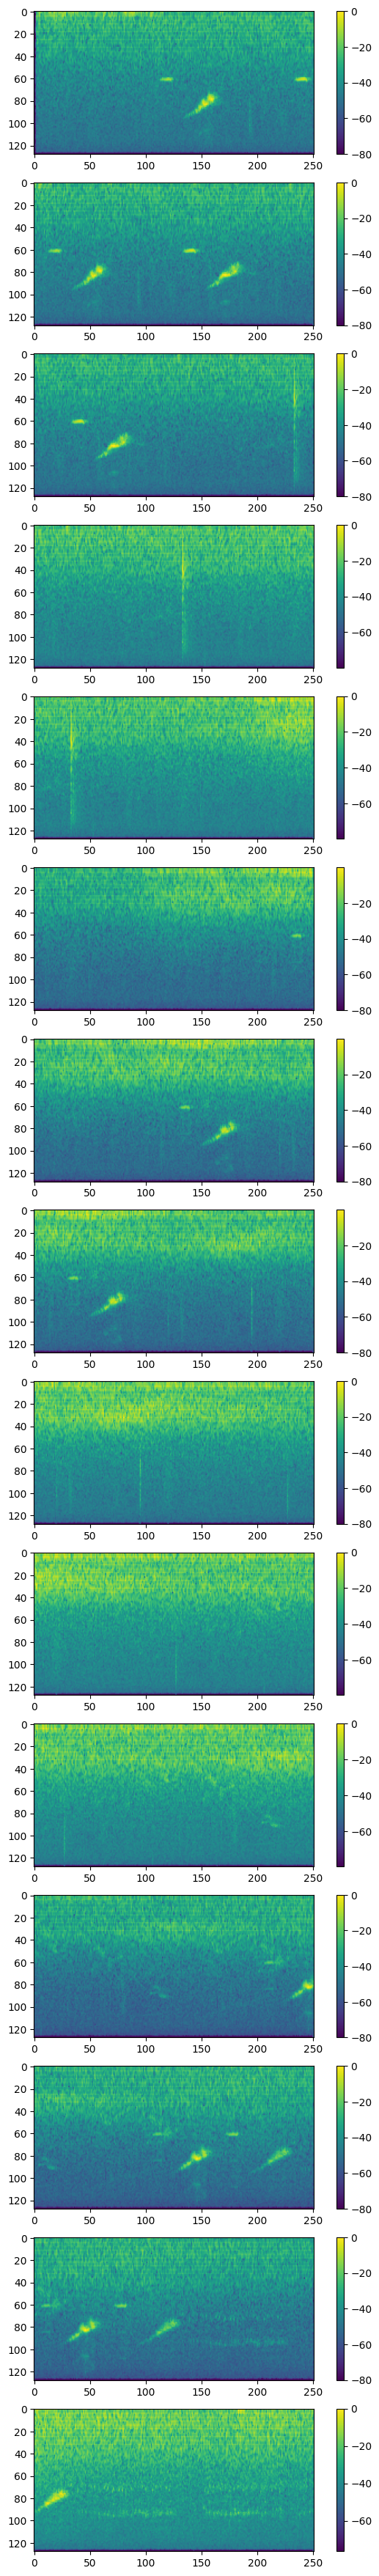

In [13]:
#MelSpectogram for a Sample
#MelSpectogram for the Apapan Audio subfolder

path_audio = os.path.join("/kaggle/input/birdclef-2022/train_audio", "apapan/XC27331.ogg")
print(path_audio)
sgs = create_spectrogram(path_audio, reduce_noise=False)


fig, axarr = plt.subplots(nrows=len(sgs), figsize=(8, 3 * len(sgs)))
for i, sg in enumerate(sgs):
    print(np.min(sg), np.max(sg))
    im = axarr[i].imshow(sg)  # librosa
    plt.colorbar(im, ax=axarr[i])

In [14]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures
from tqdm import tqdm

# Function to create a Mel Spectrogram
def create_spectrogram(file_path, reduce_noise=False):
    y, sr = librosa.load(file_path, sr=None)

    # Compute Mel Spectrogram
    mel_sg = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    
    # Convert to log scale (dB)
    mel_sg_db = librosa.power_to_db(mel_sg, ref=np.max)
    return mel_sg_db

# Function to process and visualize spectrograms for a given batch
def process_batch(batch_files):
    fig, axarr = plt.subplots(nrows=len(batch_files), figsize=(8, 3 * len(batch_files)))
    for i, file_path in enumerate(batch_files):
        # Create Mel spectrogram for the current audio file
        mel_sg = create_spectrogram(file_path)

        # Plot the spectrogram
        im = axarr[i].imshow(mel_sg, origin='lower', aspect='auto', cmap='viridis')
        axarr[i].set_title(os.path.basename(file_path))
        plt.colorbar(im, ax=axarr[i])

    # Save the figure for later visualization
    plt.tight_layout()
    plt.savefig(f"spectrograms_batch_{batch_files[0].split('/')[-2]}.png")
    plt.close(fig)  # Close the figure to free memory

# Function to process all audio files for a specific bird (subfolder)
def process_bird_audio_files(bird_folder):
    # Get all audio file paths in the current bird's folder
    audio_files = [os.path.join(bird_folder, f) for f in os.listdir(bird_folder) if f.endswith('.ogg')]
    
    # Split the audio files into smaller batches
    batch_size = 20  # For example, process 20 files at a time
    batches = [audio_files[i:i + batch_size] for i in range(0, len(audio_files), batch_size)]
    
    # Process each batch in parallel using concurrent futures
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Submit all batch processing tasks
        executor.map(process_batch, batches)

# Main function to process the entire dataset
def process_all_bird_data(base_path):
    bird_folders = [os.path.join(base_path, bird) for bird in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, bird))]
    
    # Iterate over each bird subfolder and process its audio files
    for bird_folder in tqdm(bird_folders, desc="Processing Birds"):
        process_bird_audio_files(bird_folder)

# Path to the train_audio folder
train_audio_path = "/kaggle/input/birdclef-2022/train_audio"

# Start processing all bird audio files
process_all_bird_data(train_audio_path)


Processing Birds:  11%|█         | 16/152 [09:48<1:07:31, 29.79s/it]/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1115
  warnings.warn(
Processing Birds: 100%|██████████| 152/152 [1:36:08<00:00, 37.95s/it]


# Version 4

In [15]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tqdm import tqdm
import cv2

# Function to preprocess spectrograms (resize, normalize)
def preprocess_spectrogram(sg, target_size=(224, 224)):
    # Resize to target size for EfficientNet
    sg_resized = cv2.resize(sg, target_size)
    # Normalize and expand dims for EfficientNet input
    sg_resized = np.expand_dims(sg_resized, axis=-1)  # Add channel dimension
    sg_resized = np.repeat(sg_resized, 3, axis=-1)  # Convert to 3 channels
    sg_resized = preprocess_input(sg_resized)  # Normalize as per EfficientNet requirements
    return sg_resized

# Function to load data and labels
def load_data(base_path, target_size=(224, 224)):
    image_data = []
    labels = []
    bird_folders = [os.path.join(base_path, bird) for bird in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, bird))]
    label_map = {bird: idx for idx, bird in enumerate(os.listdir(base_path))}
    
    for bird_folder in bird_folders:
        label = label_map[os.path.basename(bird_folder)]
        audio_files = [os.path.join(bird_folder, f) for f in os.listdir(bird_folder) if f.endswith('.ogg')]
        
        for file_path in tqdm(audio_files, desc=f"Loading {os.path.basename(bird_folder)}", disable=True):
            mel_sg = create_spectrogram(file_path)
            mel_sg_preprocessed = preprocess_spectrogram(mel_sg, target_size)
            image_data.append(mel_sg_preprocessed)
            labels.append(label)
    
    return np.array(image_data), np.array(labels), label_map

# Load data (Assuming the train_audio directory path)
base_path = '/kaggle/input/birdclef-2022/train_audio'
X, y, label_map = load_data(base_path)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator instance with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize images to [0,1]
    rotation_range=20,  # Random rotation of up to 20 degrees
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill mode for new pixels
)

# For validation, we usually don't augment, just rescale
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for training and validation data
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Build EfficientNet model
def build_efficientnet_model(num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model layers
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Multi-class classification
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Build the model
num_classes = len(label_map)  # Number of bird species
model = build_efficientnet_model(num_classes)

# Train the model using the augmented data
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Evaluate the model using macro F1 score

# Get predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate macro F1 score
f1 = f1_score(y_val, y_pred_classes, average='macro')
print(f'Macro F1 Score: {f1}')

/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1115
  warnings.warn(


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

# Version 3

In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tqdm import tqdm
import cv2

# Function to preprocess spectrograms (resize, normalize)
def preprocess_spectrogram(sg, target_size=(224, 224)):
    # Resize to target size for EfficientNet
    sg_resized = cv2.resize(sg, target_size)
    # Normalize and expand dims for EfficientNet input
    sg_resized = np.expand_dims(sg_resized, axis=-1)  # Add channel dimension
    sg_resized = np.repeat(sg_resized, 3, axis=-1)  # Convert to 3 channels
    sg_resized = preprocess_input(sg_resized)  # Normalize as per EfficientNet requirements
    return sg_resized

# Function to load data and labels
def load_data(base_path, target_size=(224, 224)):
    image_data = []
    labels = []
    bird_folders = [os.path.join(base_path, bird) for bird in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, bird))]
    label_map = {bird: idx for idx, bird in enumerate(os.listdir(base_path))}
    
    for bird_folder in bird_folders:
        label = label_map[os.path.basename(bird_folder)]
        audio_files = [os.path.join(bird_folder, f) for f in os.listdir(bird_folder) if f.endswith('.ogg')]
        
        for file_path in tqdm(audio_files, desc=f"Loading {os.path.basename(bird_folder)}", disable=True):
            mel_sg = create_spectrogram(file_path)
            mel_sg_preprocessed = preprocess_spectrogram(mel_sg, target_size)
            image_data.append(mel_sg_preprocessed)
            labels.append(label)
    
    return np.array(image_data), np.array(labels), label_map

# Load data (Assuming the train_audio directory path)
base_path = '/kaggle/input/birdclef-2022/train_audio'
X, y, label_map = load_data(base_path)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator instance with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize images to [0,1]
    rotation_range=20,  # Random rotation of up to 20 degrees
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill mode for new pixels
)

# For validation, we usually don't augment, just rescale
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for training and validation data
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Build EfficientNet model
def build_efficientnet_model(num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model layers
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Multi-class classification
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Build the model
num_classes = len(label_map)  # Number of bird species
model = build_efficientnet_model(num_classes)

# Train the model using the augmented data
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Evaluate the model using macro F1 score
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate macro F1 score
f1 = f1_score(y_val, y_pred_classes, average='macro')
print(f'Macro F1 Score: {f1}')


In [ ]:

# Optionally, plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tqdm import tqdm
import cv2

# Function to preprocess spectrograms (resize, normalize)
def preprocess_spectrogram(sg, target_size=(224, 224)):
    # Resize to target size for EfficientNet
    sg_resized = cv2.resize(sg, target_size)
    # Normalize and expand dims for EfficientNet input
    sg_resized = np.expand_dims(sg_resized, axis=-1)  # Add channel dimension
    sg_resized = np.repeat(sg_resized, 3, axis=-1)  # Convert to 3 channels
    sg_resized = preprocess_input(sg_resized)  # Normalize as per EfficientNet requirements
    return sg_resized

# Function to load data and labels
def load_data(base_path, target_size=(224, 224)):
    image_data = []
    labels = []
    bird_folders = [os.path.join(base_path, bird) for bird in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, bird))]
    label_map = {bird: idx for idx, bird in enumerate(os.listdir(base_path))}
    
    for bird_folder in bird_folders:
        label = label_map[os.path.basename(bird_folder)]
        audio_files = [os.path.join(bird_folder, f) for f in os.listdir(bird_folder) if f.endswith('.ogg')]
        
        for file_path in tqdm(audio_files, desc=f"Loading {os.path.basename(bird_folder)}", disable=True):
            mel_sg = create_spectrogram(file_path)
            mel_sg_preprocessed = preprocess_spectrogram(mel_sg, target_size)
            image_data.append(mel_sg_preprocessed)
            labels.append(label)
    
    return np.array(image_data), np.array(labels), label_map

# Load data (Assuming the train_audio directory path)
base_path = '/kaggle/input/birdclef-2022/train_audio'
X, y, label_map = load_data(base_path)

from imblearn.over_sampling import SMOTE

# Use SMOTE to create synthetic samples for minority classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# Build EfficientNet model
def build_efficientnet_model(num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model layers
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Multi-class classification
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Build the model
num_classes = len(label_map)  # Number of bird species
model = build_efficientnet_model(num_classes)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Evaluate the model using macro F1 score
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate macro F1 score
f1 = f1_score(y_val, y_pred_classes, average='macro')
print(f'Macro F1 Score: {f1}')

# Optionally, plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tqdm import tqdm
import cv2

# Load data (Assuming the train_audio directory path)
base_path = '/kaggle/input/birdclef-2022/train_audio'
X, y, label_map = load_data(base_path)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Build EfficientNet model
def build_efficientnet_model(num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model layers
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Multi-class classification
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Build the model
num_classes = len(label_map)  # Number of bird species
model = build_efficientnet_model(num_classes)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Evaluate the model using macro F1 score
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate macro F1 score
f1 = f1_score(y_val, y_pred_classes, average='macro')
print(f'Macro F1 Score: {f1}')


#  Alternate Way:

In [ ]:
from PIL import Image
from tqdm.auto import tqdm
from functools import partial
from joblib import Parallel, delayed


def convert_and_export(
    fn: str, path_in: str, path_out: str,
    reduce_noise: bool = False,
    frame_size: int = 5, frame_step: int = 2,
    img_extension=".png",
) -> None:
    path_audio = os.path.join(path_in, fn)
    try:
        sgs = create_spectrogram(
            path_audio,
            reduce_noise=reduce_noise,
            frame_size=frame_size,
            frame_step=frame_step,
        )
    except Exception as ex:
        print(f"Failed conversion for audio: {path_audio}")
        return
    if not sgs:
        print(f"Too short audio for: {path_audio}")
        return
    # see: https://www.kaggle.com/c/birdclef-2022/discussion/308861
    # this is adjustment for window 5s and step 2s
    nb = ceil((10 - frame_size) / frame_step) + 1
    if len(sgs) > 2 * nb:
        sgs = sgs[:nb] + sgs[-nb:]
    path_npz = os.path.join(path_out, fn + '.npz')
    os.makedirs(os.path.dirname(path_npz), exist_ok=True)
    # np.savez_compressed(path_npz, np.array(sgs, dtype=np.float16))
    for i, sg in enumerate(sgs):
        path_img = os.path.join(path_out, fn + f".{i:03}" + img_extension)
        try:
            # plt.imsave(path_img, sg, vmin=-70, vmax=20)
            sg = (sg + 80) / 80.0
            sg = np.clip(sg, a_min=0, a_max=1) * 255
            img = Image.fromarray(sg.astype(np.uint8))
            img.resize((256,256)).save(path_img)
        except Exception as ex:
            print(f"Failed exporting for image: {path_img}")
            continue

In [ ]:
_convert_and_export = partial(
    convert_and_export,
    path_in=os.path.join("/kaggle/input/birdclef-2022/train_audio"),
    path_out="train_images",
)

_= Parallel(n_jobs=3)(delayed(_convert_and_export)(fn) for fn in tqdm(extra_data["filename"]))